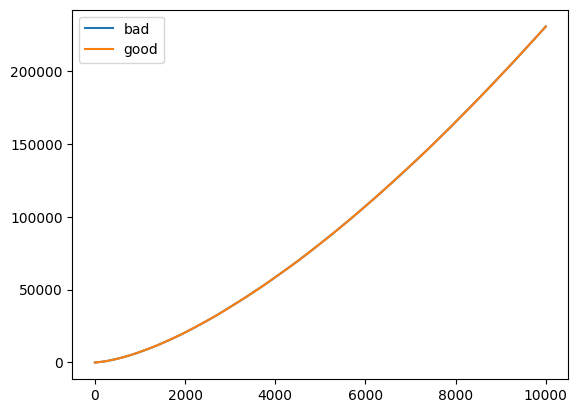

-0.9206530245182306


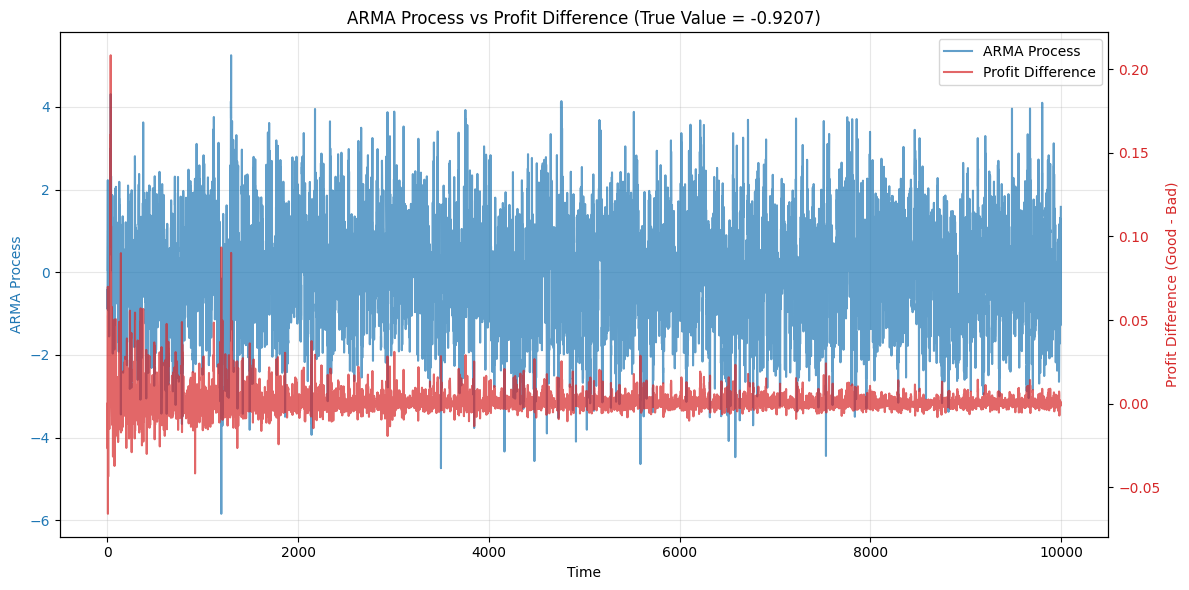

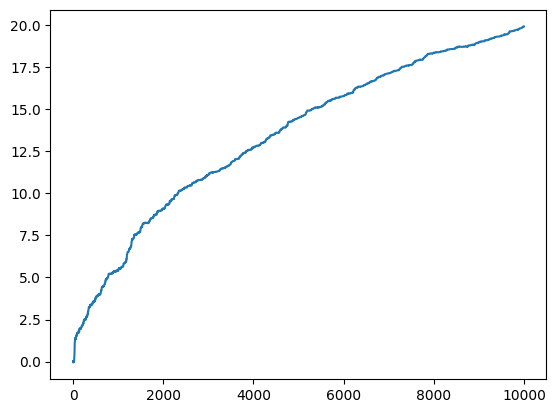

19.906523025099887


In [1]:
#ToDo
# find real stock data that is sampled at a constant rate
# first by yourself determine what it is ARMA(p, q) based on statsmodel - in homework
# then switch the get_ma_process function to the real stock data
# then change the predict_next_ar2 function to predict based on ARMA(p, q) and past data

import numpy as np
from statsmodels.tsa.arima_process import ArmaProcess
from matplotlib import pyplot as plt

def get_ma_process(phi0, phi1, T):
    ar_process = ArmaProcess([1, -phi0, -phi1], [1])
    return ar_process.generate_sample(nsample=T)

def predict_next_ar2(u_series, phi0, phi1, t):
    """Predict the next value in an AR(2) process"""
    if t < 2:
        return 0  # Not enough history
    return phi0 * u_series[t-1] + phi1 * u_series[t-2]

    
def run_simulation(phi0, phi1):
    # parameters
    T = 10000
    v = np.random.normal(0, 1.0)
    sigma_u = sigma_v = 1.0
    thetas = np.zeros(T)
    u = get_ma_process(phi0, phi1, T)
    # plt.plot(u)
    # plt.show()
    q = 0.0
    profits_bad = np.zeros(T)
    profits_good = np.zeros(T)
    for k in range(T):
        var_q = thetas[k]**2 * sigma_v**2 + (4/3) * sigma_u**2 * (1 - (1/4)**(k+1))
        lambda_k = sigma_v / np.sqrt(var_q + 4 * sigma_u**2)
        
        noise_before = []
        for i in range(1, 3):
            if k-i >= 0:
                noise_before.append(u[k-i])
        best_guess = predict_next_ar2(u, phi0, phi1, k)
        x_good = (v - lambda_k*(q + best_guess)) / (2*lambda_k)
        x_bad = (v - lambda_k*(q)) / (2*lambda_k)
        price_bad = lambda_k*(x_bad + q + u[k])
        price_good = lambda_k*(x_good + q + u[k])
        profit_bad = (v - price_bad)*x_bad
        profit_good = (v - price_good)*x_good
        profits_bad[k] = profit_bad
        profits_good[k] = profit_good
        if k < T-1:
            thetas[k+1] = thetas[k]/2 + 1/(2*lambda_k)

    # plt.plot(profits_bad, label='bad')
    # plt.plot(profits_good, label='good')
    # plt.legend()
    # plt.show()
    cum_profits_bad = np.cumsum(profits_bad)
    cum_profits_good = np.cumsum(profits_good)
    plt.plot(cum_profits_bad, label='bad')
    plt.plot(cum_profits_good, label='good')
    plt.legend()
    plt.show()
    print(v)

    # Create dual y-axis plot showing ARMA process and profit difference
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot ARMA process on left y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('ARMA Process', color=color)
    ax1.plot(u, color=color, alpha=0.7, label='ARMA Process')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Create right y-axis and plot profit difference
    ax2 = ax1.twinx()
    color = 'tab:red'
    profit_diff = profits_good - profits_bad
    ax2.set_ylabel('Profit Difference (Good - Bad)', color=color)
    ax2.plot(profit_diff, color=color, alpha=0.7, label='Profit Difference')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Add title and grid
    plt.title(f"ARMA Process vs Profit Difference (True Value = {v:.4f})")
    ax1.grid(True, alpha=0.3)
    
    # Add legend for both lines
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return cum_profits_good - cum_profits_bad  # cumulative difference

dif = run_simulation(0.4, 0.3)
plt.plot(dif)
plt.show()
print(dif[-1])


In [42]:
import pandas as pd
from pandas import Series        # To work on series 

df = pd.read_csv("A.csv")
A = df["High"].values[1000:4000]
B = df["Low"].values[1000:4000]
df.head()



,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,27.068665,62546300
1,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.838577,15234100
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.068665,6577800
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.607880,5975600
4,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.261524,4843200


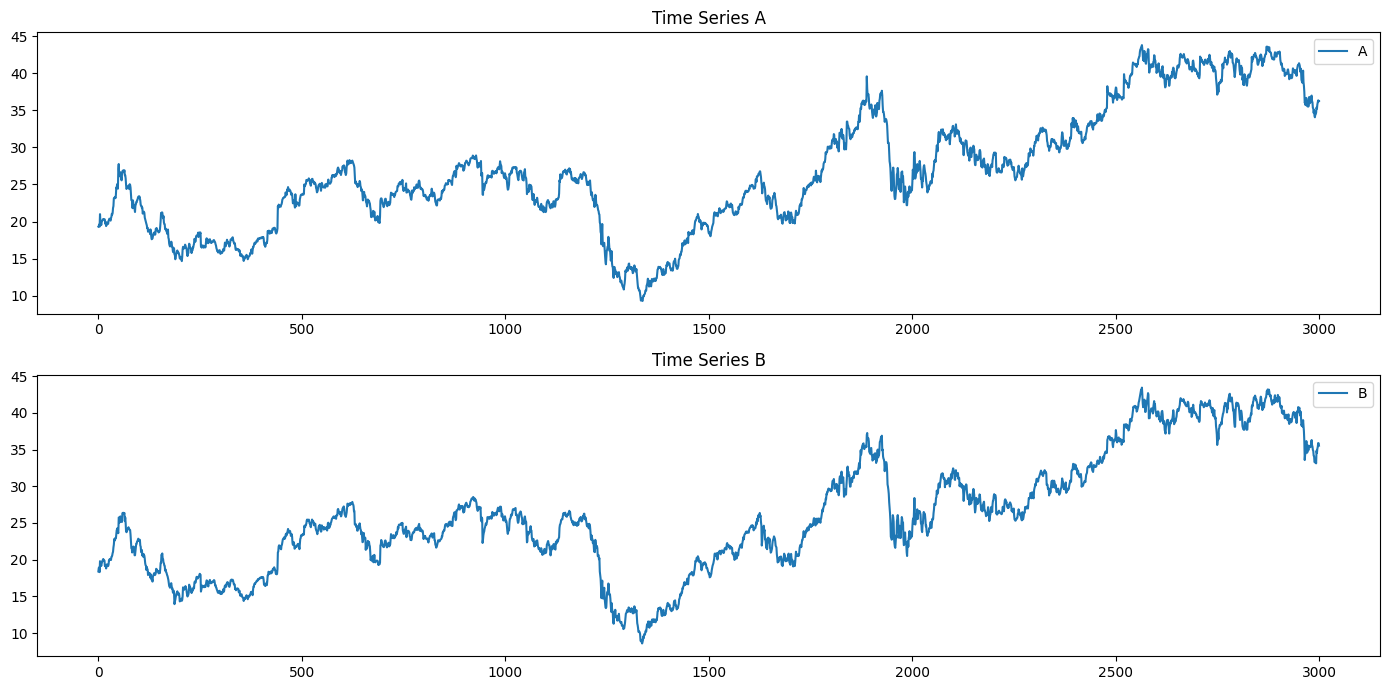

In [43]:
import matplotlib.pyplot as plt
# Plot time series A and B
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(A, label='A')
plt.title('Time Series A')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(B, label='B')
plt.title('Time Series B')
plt.legend()
plt.tight_layout()
plt.show()

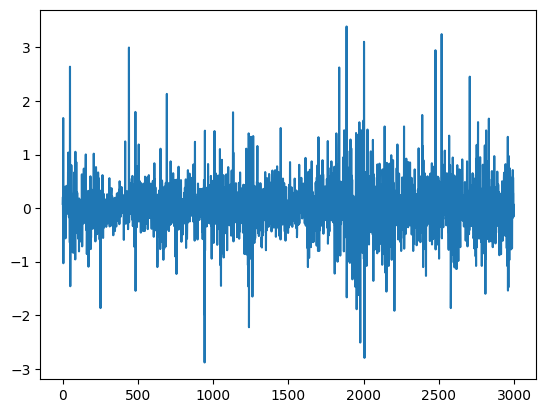

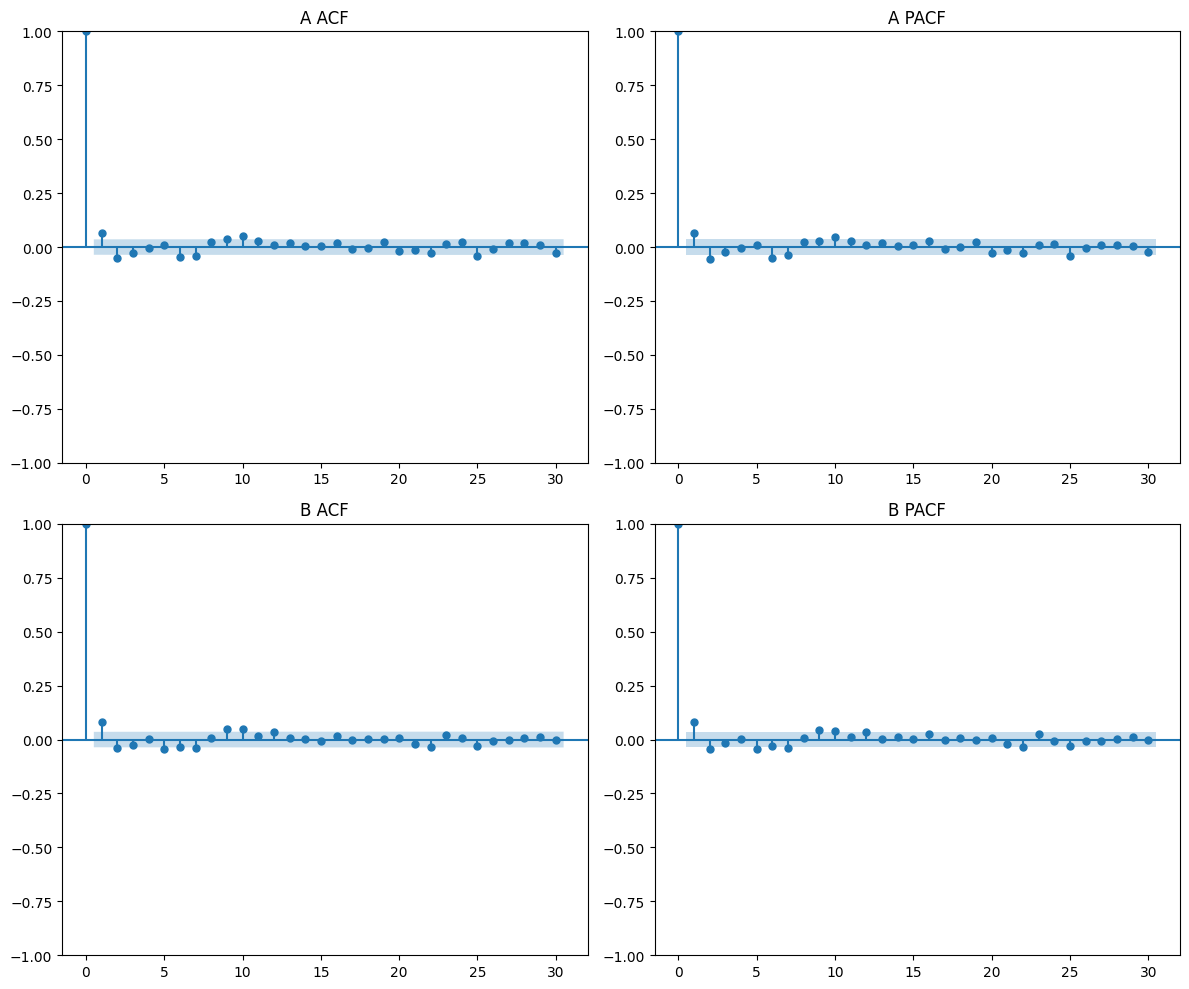

In [44]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
diff = A[1:]-A[:-1]
diffB = B[1:]-B[:-1]
plt.plot(diff)
plt.show()
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
plot_acf(diff, lags=30, ax=axs[0][0])
axs[0][0].set_title("A ACF")
plot_pacf(diff, lags=30, ax=axs[0][1])
axs[0][1].set_title("A PACF")
plot_acf(diffB, lags=30, ax=axs[1][0])
axs[1][0].set_title("B ACF")
plot_pacf(diffB, lags=30, ax=axs[1][1])
axs[1][1].set_title("B PACF")
plt.tight_layout()
plt.show()

In [57]:
from statsmodels.tsa.arima.model import ARIMA
mod_A = ARIMA(endog=diff, order=(2, 0, 2), trend="n")
res_A = mod_A.fit()
print(res_A.summary())
mod_B = ARIMA(endog=diffB, order=(2, 0, 2), trend="n")
res_B = mod_B.fit()
print(res_B.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2999
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1933.173
Date:                Tue, 06 May 2025   AIC                           3876.346
Time:                        12:39:53   BIC                           3906.376
Sample:                             0   HQIC                          3887.148
                               - 2999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4965      0.180      2.751      0.006       0.143       0.850
ar.L2         -0.0124      0.175     -0.071      0.944      -0.355       0.331
ma.L1         -0.4291      0.182     -2.363      0.0

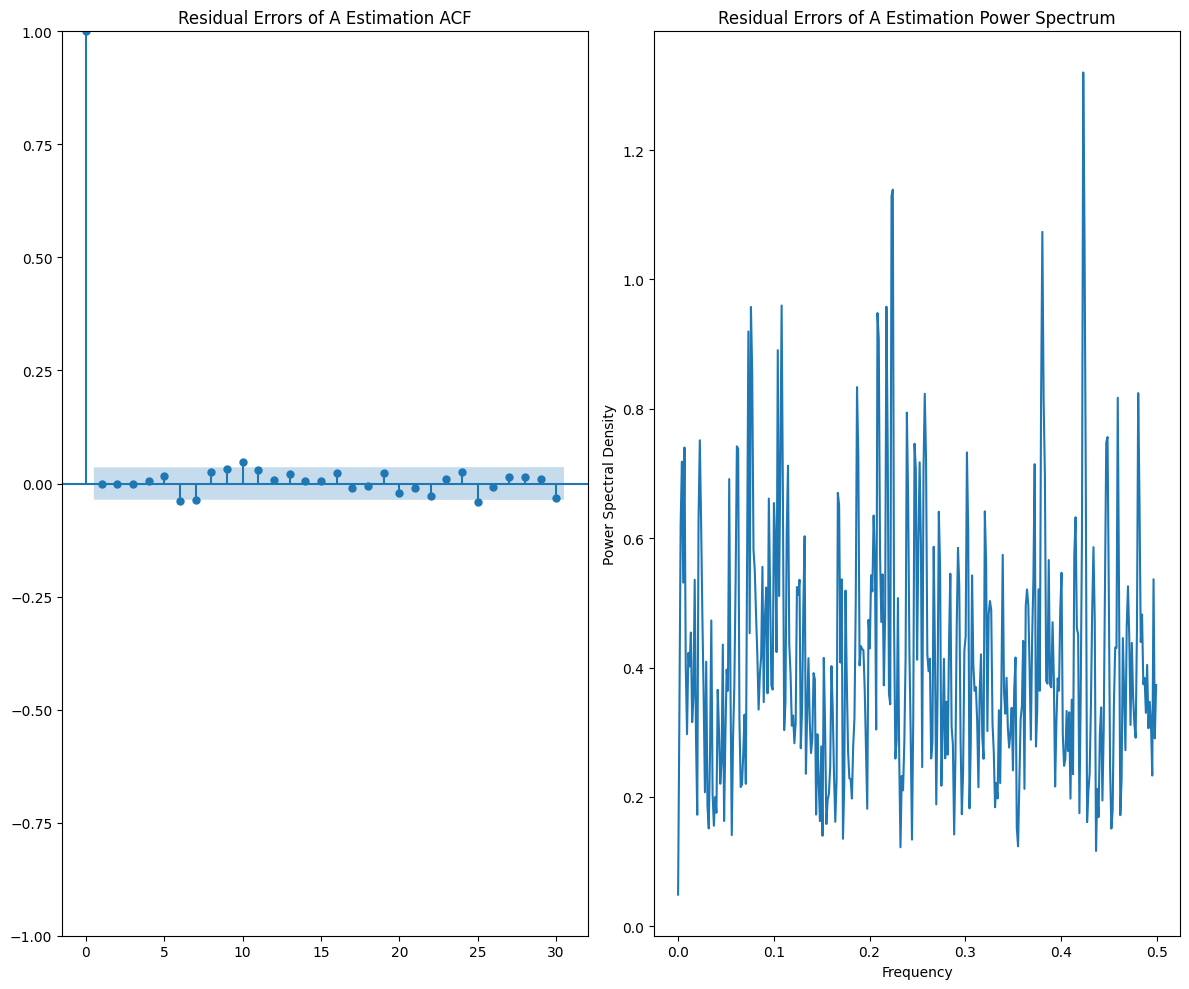

In [58]:
from scipy.signal import welch
residual_A = res_A.resid
fig, axs = plt.subplots(1, 2, figsize=(12, 10))
plot_acf(residual_A, lags=30, ax=axs[0])
axs[0].set_title("Residual Errors of A Estimation ACF")
freqs, psd = welch(residual_A, fs=1, nperseg=len(residual_A)//4)
axs[1].plot(freqs, psd)
axs[1].set_xlabel("Frequency")
axs[1].set_ylabel("Power Spectral Density")
axs[1].set_title("Residual Errors of A Estimation Power Spectrum")
plt.tight_layout()
plt.show()

In [59]:
from statsmodels.stats.diagnostic import acorr_ljungbox
print(acorr_ljungbox(residual_A))

      lb_stat  lb_pvalue
1    0.000053   0.994204
2    0.000605   0.999697
3    0.011941   0.999654
4    0.123004   0.998185
5    1.007940   0.961923
6    5.634804   0.465316
7    9.470133   0.220640
8   11.318817   0.184281
9   14.442790   0.107423
10  21.537944   0.017640


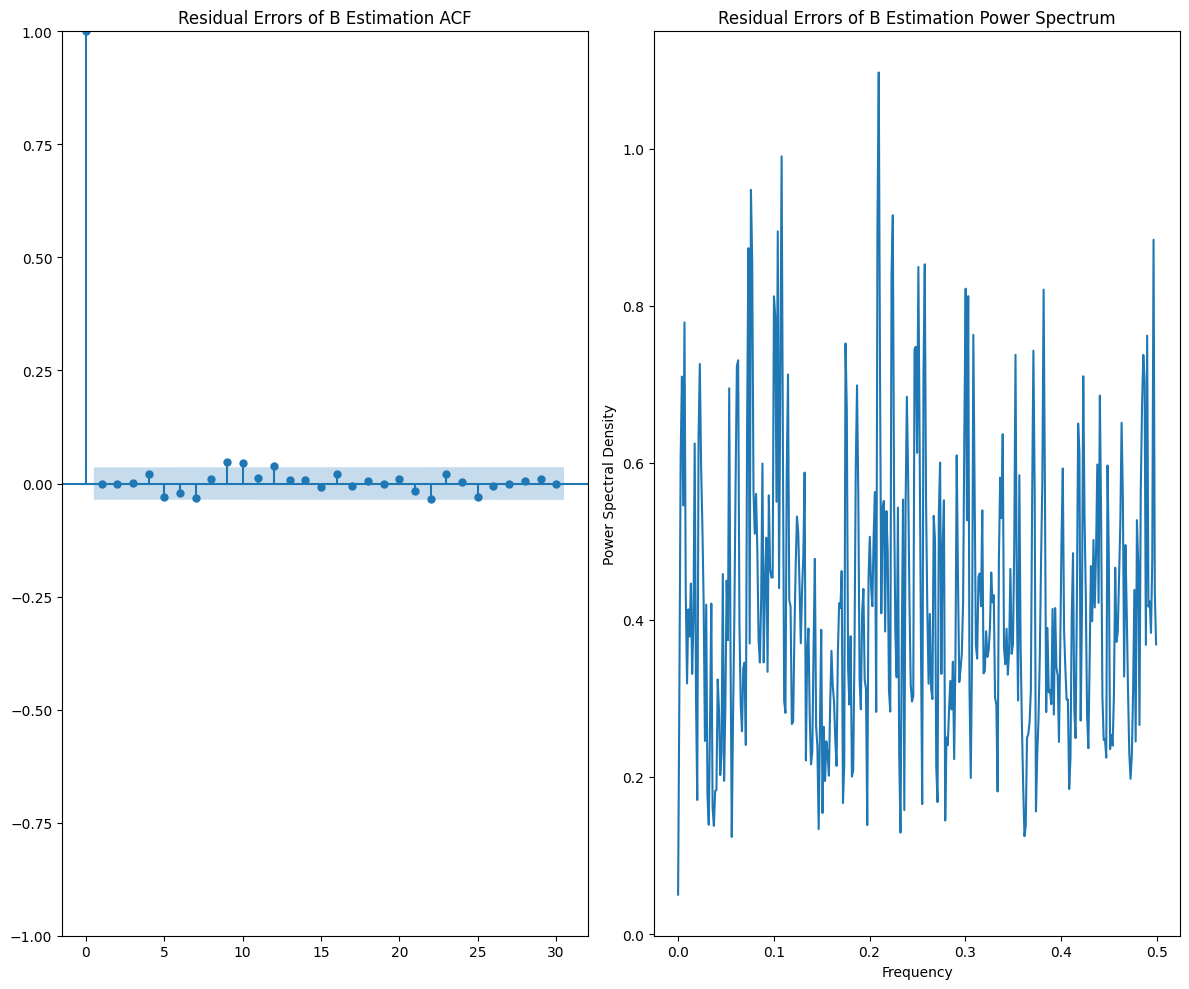

      lb_stat  lb_pvalue
1    0.000071   0.993282
2    0.000254   0.999873
3    0.007093   0.999841
4    1.417342   0.841175
5    4.228468   0.517013
6    5.531651   0.477640
7    8.567848   0.285189
8    8.843061   0.355708
9   15.595348   0.075828
10  21.569519   0.017454


In [50]:
residual_B = res_B.resid
fig, axs = plt.subplots(1, 2, figsize=(12, 10))
plot_acf(residual_B, lags=30, ax=axs[0])
axs[0].set_title("Residual Errors of B Estimation ACF")
freqs, psd = welch(residual_B, fs=1, nperseg=len(residual_B)//4)
axs[1].plot(freqs, psd)
axs[1].set_xlabel("Frequency")
axs[1].set_ylabel("Power Spectral Density")
axs[1].set_title("Residual Errors of B Estimation Power Spectrum")
plt.tight_layout()
plt.show()
print(acorr_ljungbox(residual_B))